<img src="https://github.com/FarzadNekouee/Garbage_Classification_ResNet50_Scratch_to_Transfer-Learning/blob/master/images/Cover_Image_txt.png?raw=true" width="2400">

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">

<h1 align="left"><font color=royalblue>Description: </font></h1>
    
In this project, we aim to develop a light weight garbage classification system leveraging the MobileNet architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation.

<div style="border-radius:10px; padding: 15px; background-color: black; font-size:125%; text-align:left">

<h1 align="left"><font color=royalblue>Objectives:</font></h1>
    

- **Dataset Exploration:** Dive into the garbage dataset, emphasizing class imbalances.
- **Tackle Imbalance:** Utilize class weights in the loss function to address dataset disparities.
- **Implement Data Augmentation:** Enhance model generalization and combat overfitting.
- **Construct MobileNet:** Design a custom MobileNet for garbage classification from scratch.
- **Employ Transfer Learning:** Leverage a pre-trained MobileNet, adapting it for our specific dataset.
- **Evaluate Models:** Assess both models' performance using varied metrics to ensure reliable classification.


<a id="contents_tabel"></a>    
<div style="border-radius:10px; padding: 15px; background-color: black; font-size:125%; text-align:left">

<h1 align="left"><font color=royalblue>Table of Contents:</font></h1>
    
* [Step 1 | Setup and Initialization](#Initialization)
* [Step 2 | Dataset Analysis](#Dataset_Analysis)
* [Step 3 | Dataset Preparation](#Dataset_Preparation)
    - [Step 3.1 | Centralize Dataset Information](#Centralize_Dataset)
    - [Step 3.2 | Stratified Data Splitting: Train & Validation](#Splitting_Dataset)
    - [Step 3.3 | Data Augmentation & Rescaling](#Data_Augmentation)
    - [Step 3.4 | Generating Batches of Images](#Generate_Batch)
* [Step 4 | Addressing Dataset Imbalances](#Dataset_Imbalances)
* [Step 5 | MobileNet Built from Scratch](#MobileNet)
    - [Step 5.1 | Defining the MobileNet Architecture from Scratch](#Define_Scratch)
    - [Step 5.2 | Training the Defined MobileNet Model](#Train_Scratch)
    - [Step 5.3 | Evaluating the Defined MobileNet Model](#Eval_Scratch)
* [Step 6 | MobileNet with Transfer Learning](#Transfer_Learning)
    - [Step 6.1 | Loading MobileNet with Pre-trained Weights](#Define_tf)
    - [Step 6.2 | Applying MobileNet-specific Image Preprocessing](#Preprocess_tf)
    - [Step 6.3 | Fine-tuning the Transfer Learning MobileNet Model](#Train_tf)
    - [Step 6.4 | Evaluating the Transfer Learning MobileNet Model](#Eval_tf)

<h2 align="left"><font color=royalblue>Let's get started:</font></h2>

<a id="Initialization"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 1 | Setup and Initialization</p>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">

First, we will bring in the libraries we need for this project:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import setuptools.dist
import tensorflow as tf
# %pip install tensorflow==2.15
from google.colab import drive

from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import DepthwiseConv2D, BatchNormalization, ReLU, Conv2D, Dropout
from keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNet as PretrainedMobileNet

<a id="Dataset_Analysis"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 2 | Dataset Analysis</p>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">
    
We are going to take a look inside the different folders of the dataset containing different garbage types. For each garbage type, we will count its pictures and check if they all have the same size. Then, we will display these details for every garbage type:

In [ ]:
# Define the path where your dataset is stored in Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

dataset_path = '/content/drive/MyDrive/Garbagage_classification/TrashType_Image_Dataset'  # Adjust this path as needed

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))

# Determine if all images in the entore dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

Mounted at /content/drive
trash folder contains 137 images.
glass folder contains 501 images.
paper folder contains 594 images.
plastic folder contains 482 images.
cardboard folder contains 403 images.
metal folder contains 410 images.

All images in the dataset have the same dimensions: 512x384 with 3 color channels.


<div style="border-radius:10px; padding: 15px; background-color:black; font-size:120%; text-align:left">

<h2 align="left"><font color=royalblue>📊 Inference on Class Imbalance</font></h2>


The "Garbage Image Dataset" reveals a noticeable imbalance in the distribution of its image categories:

- **cardboard**: 403 images
- **glass**: 501 images
- **metal**: 410 images
- **paper**: 594 images
- **plastic**: 482 images
- **trash**: 137 images

Imbalanced datasets in Convolutional Neural Networks (CNNs) occur when some classes have significantly more samples than others. This imbalance can cause the CNN to become biased toward the majority classes, leading to poor generalization on minority classes, which are often underrepresented.

This can lead to:

1️⃣ **Bias**: The model might lean towards predicting "paper" often because it's seen it more during training.
    
    
2️⃣ **Poor Generalization**: If we deploy our model in a real-world scenario where "trash" items are just as common as "paper" items, our model might not perform well.

    
3️⃣ **Accuracy Deception**: The model could seem highly accurate if it keeps guessing the dominant class, but it might be weak in detecting underrepresented classes like "trash".

To create an efficient classifier, addressing this imbalance is crucial.

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">
    
Let's visually explore the images from each garbage category:

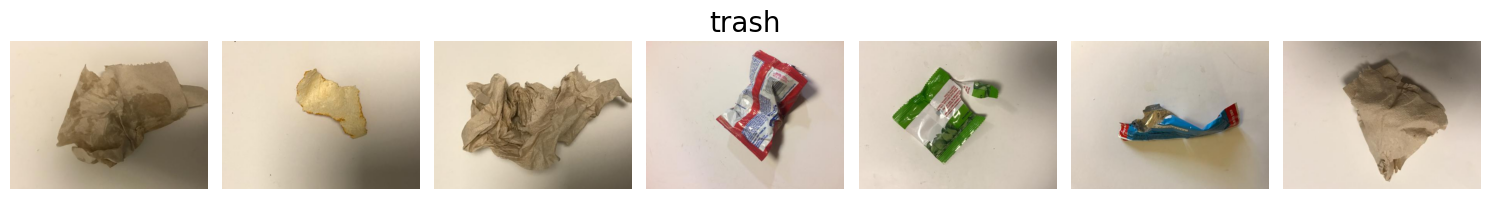

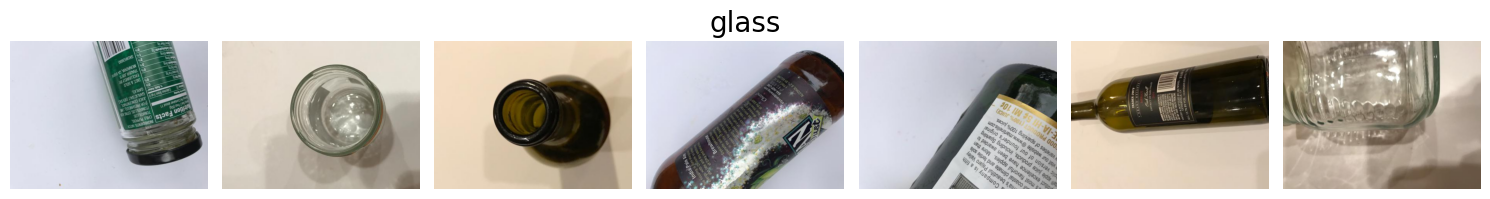

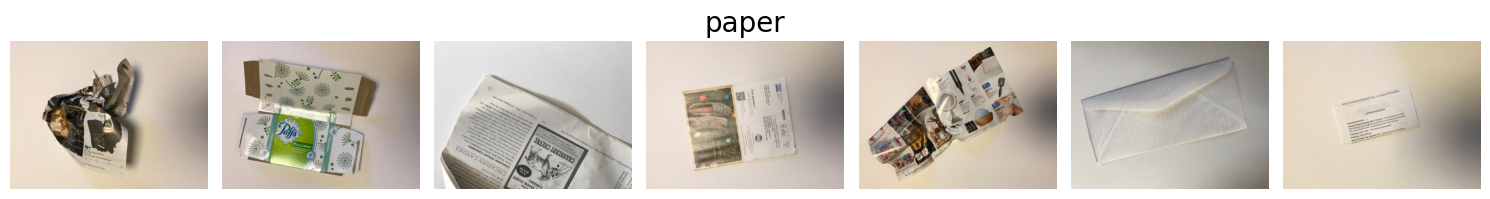

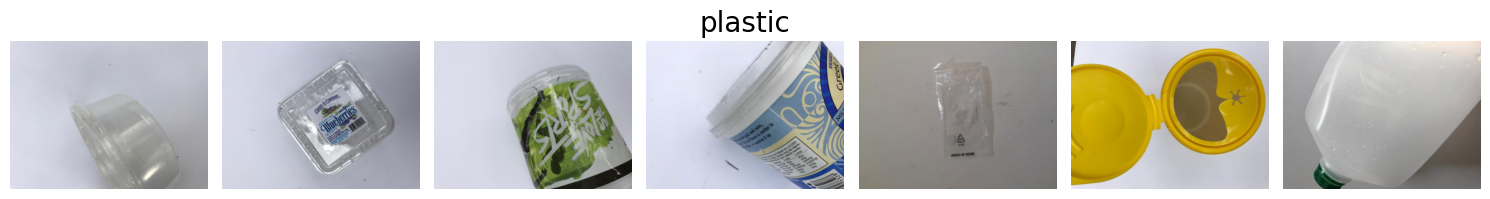

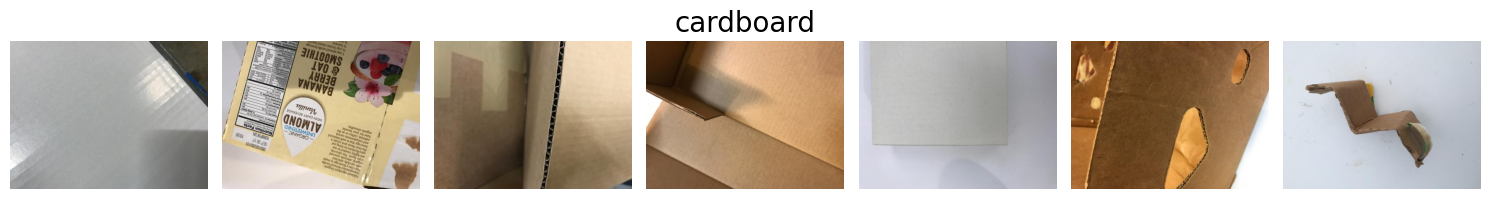

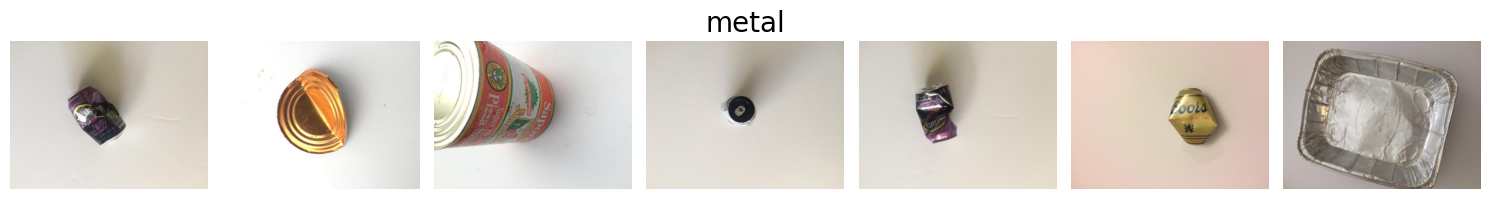

In [ ]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Select the first 10 images
        image_files = image_files[:7]

        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

<a id="Dataset_Preparation"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 3 | Dataset Preparation</p>
⬆️ [Tabel of Contents](#contents_tabel)

<a id="Centralize_Dataset"></a>
# <b><span style='color:darkturquoise'>Step 3.1 |</span><span style='color:royalblue'> Centralize Dataset Information</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:120%; text-align:left">

### 🔍 <span style="color:royalblue">Concern:</span>
We have all our images scattered across multiple folders, one for each garbage class. We need a unified view of the data for easy manipulation.

### 🛠️ <span style="color:royalblue">Strategy:</span>
Create a DataFrame that contains file paths and corresponding labels.

In [ ]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,/content/drive/MyDrive/Garbagage_classificatio...,trash
1,/content/drive/MyDrive/Garbagage_classificatio...,trash
2,/content/drive/MyDrive/Garbagage_classificatio...,trash
3,/content/drive/MyDrive/Garbagage_classificatio...,trash
4,/content/drive/MyDrive/Garbagage_classificatio...,trash


<a id="Splitting_Dataset"></a>
# <b><span style='color:darkturquoise'>Step 3.2 |</span><span style='color:royalblue'> Stratified Data Splitting: Train & Validation</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:120%; text-align:left">
    
### 🔍 <span style="color:royalblue">Concern:</span>
To ensure our train and validation sets represent all garbage classes well, and to avoid potential biases associated with the order of images, we need the sets to have a similar distribution of classes as the whole dataset and also be shuffled.

### 🛠️ <span style="color:royalblue">Strategy:</span>
Employ stratified sampling through `train_test_split`, which inherently shuffles and divides the DataFrame while maintaining a consistent distribution of classes.

In [ ]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 2021
Number of images in the validation set: 506


<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">
    
Let's verify that the distributions in the training and validation sets closely mirror the overall distribution:

In [ ]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📊 Inference on Stratification Effectiveness</font></h2>

The class distributions in both the training and validation sets closely mirror the overall distribution in the entire dataset, indicating that stratification during the split was successful.

<a id="Data_Augmentation"></a>
# <b><span style='color:darkturquoise'>Step 3.3 |</span><span style='color:royalblue'> Data Augmentation & Rescaling</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">
    
### 🔍 <span style="color:royalblue">Concern:</span>
- We have limited images, so we risk overfitting.
- Neural networks work better with input values between 0 and 1, but our images have pixel values between 0 and 255.

### 🛠️ <span style="color:royalblue">Strategy:</span>
- Augment the training images to artificially increase dataset size.
- Rescale both training and validation images for better network performance.

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📌 Note on Data Augmentation in Validation Set</font></h2>

__Data augmentation__ is a technique primarily used to expand the training dataset in order to improve the model's capacity to generalize and avoid overfitting. The primary objective is to introduce variability and mimic potential real-world distortions in the training images without actually collecting more data.

On the other hand, the validation set's role is to provide an unbiased evaluation of a model's performance on unseen data. Thus, we want the validation data to remain consistent throughout the model's training process to ensure that our evaluations are stable and reproducible. Applying augmentations to the validation set would introduce random variability in the evaluation metrics across different epochs, making it harder to determine whether changes in the model's performance are due to the model's learning or just the variability introduced by augmentations.

Therefore, to maintain a consistent and clear evaluation benchmark, I refrain from applying data augmentation to the validation set, using only rescaling to ensure the pixel values are in a similar range as the augmented training images.

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📌 Designing Data Augmentation for Trash Classification</font></h2>

Based on the dataset, here are some observations regarding the potential data augmentation techniques:

<h3 align="left"><font color=royalblue>Suitable Transformations:</font></h3>

- __Rescaling__: Necessary to normalize pixel values between 0 and 1.
- __Rotation__: Captures objects in various orientations.
- __Width and Height Shift__: Models minor positional changes.
- __Zoom__: Simulates different object distances.
- __Flip__: Captures different horizontal or vertical orientations.
- __Shear__: Provides a skewed perspective of images.
- __Brightness Adjustment__: Adapts images to diverse lighting conditions.
- __Channel Shift__: Alters colors for added variety.
- __Fill Mode__: Addresses missing pixel values.

In [ ]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

<a id="Generate_Batch"></a>
# <b><span style='color:darkturquoise'>Step 3.4 |</span><span style='color:royalblue'> Generating Batches of Images</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">
    
### 🔍 <span style="color:royalblue">Concern:</span>
- We can't load all images at once due to memory constraints.
- We want to benefit from the DataFrame format to feed our images into our model.
- Most CNN architectures often perform better with square images.
- We aim to avoid manual one-hot encoding of labels.
- Ensuring consistent ordering and reproducibility during training.

### 🛠️ <span style="color:royalblue">Strategy:</span>
- Use the `flow_from_dataframe` method to generate batches of images and labels directly from our DataFrame.
- Rescale images to 224x224 to maintain a square shape, aligning with the design preferences of CNNs.
- Leverage the initial shuffling done through `train_test_split` to randomize data order, eliminating the need for additional shuffling in the generators.
- Use a seed (`seed=0`) during data augmentation to ensure reproducibility of transformations across runs.

In [ ]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(224, 224),              # Resize all images to size of 224x224
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(224, 224),              # Resize all images to size of 224x224
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [ ]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📌 Understanding ImageDataGenerator</font></h2>

When we create `train_generator` using `flow_from_dataframe`, we're __not__ pre-generating all batches of images with their transformations. What we are doing is setting up a framework or a "__pipeline__" that knows how to fetch and transform the images when requested.

The benefit of ImageDataGenerator is precisely this: it generates augmented images __on-the-fly__ during each step of each epoch. It doesn't pre-generate and store them.

When we ask for `len(train_generator)`, it's just doing a calculation based on the total number of images and the batch size to tell us how many batches there will be. It doesn't mean those batches have been pre-generated.

<a id="Dataset_Imbalances"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 4 | Addressing Dataset Imbalances</p>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>🛠️ Addressing Imbalance Using Class Weights:</font></h2>

To tackle our imbalanced image dataset, we'll utilize class weights. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like `compute_class_weight` from scikit-learn based on the distribution of images in each class. The formula is:

$$ \text{weight}(class) = \frac{\text{total samples}}{\text{number of classes} \times \text{samples in that class}} $$

These computed weights are then passed to the model


In [ ]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [ ]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [ ]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([3.06212121, 0.83998337, 0.70912281, 1.02693089, 0.87489177,
       1.04606625])

In [ ]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📌 Understanding Class Label Mapping in ImageDataGenerator:</font></h2>

When we create a generator using __`flow_from_dataframe`__ with the __`class_mode='categorical'`__ setting, the generator internally maps each unique class label in our `y_col` (in this case, the "label" column of __`train_df`__) to a unique integer. This mapping is done in alphabetical order, which means:

- '__cardboard__' is mapped to __0__
- '__glass__' is mapped to __1__
- '__metal__' is mapped to __2__
- '__paper__' is mapped to __3__
- '__plastic__' is mapped to __4__
- '__trash__' is mapped to __5__

This mapping is stored in the __`train_generator.class_indices`__ dictionary. The keys of this dictionary are the class labels (e.g., 'cardboard', 'glass', etc.), and the corresponding values are the mapped integers (e.g., 0, 1, etc.).

This mapping ensures that when we're using one-hot encoding, the correct position in the one-hot encoded vector corresponds to the appropriate class. For example, the one-hot encoded vector for 'cardboard' would be __`[1, 0, 0, 0, 0, 0]`__.

When we computed the __`class_weights`__, we used this mapping to ensure the weights correspond correctly to the one-hot encoded labels during training.

<a id="MobileNetV2"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 5 | MobileNetV1 Built from Scratch</p>
⬆️ [Tabel of Contents](#contents_tabel)

<a id="Define_Scratch"></a>
# <b><span style='color:darkturquoise'>Step 5.1 |</span><span style='color:royalblue'> Defining the MobileNetV1 Architecture from Scratch</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">

For this phase of our project, we've chosen to work with the __MobileNet__ architecture. The standout feature of MobileNet architectures is the use of depthwise separable convolutions, which factorize a standard convolution into two simpler operations: "__depthwise convolution__" (which applies a single filter per input channel) and "__pointwise convolution__" (which uses 1x1 convolutions to combine the results). This approach drastically reduces the number of parameters and computational complexity compared to traditional convolutional layers, making MobileNet V1 fast and efficient without significantly sacrificing accuracy.

Here's a representation of depthwise and pointwise blocks:

<div style="text-align: center">
 <img src="https://www.researchgate.net/publication/358585116/figure/fig1/AS:1127546112487425@1645839350616/Depthwise-separable-convolutions.png?raw=true" width="1200">
</div>

- All layers are followed by BatchNorm and ReLU activation function except final layer.
-Last layer used no activation function and feed into softmax layer for classification.

In [ ]:
def depth_block(x, strides):
    """
    Arguments:
    X           -- input tensor of shape (m, height, width, channels)
    stride      -- integer, strides for the convolutional layer

    Returns:
    X           -- output of the identity block, tensor of shape (height, width, channels)
    """
    x = DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(max_value=6)(x)
    return x
def single_conv_block(x,filters):
    """
    Arguments:
    X           -- input tensor of shape (m, height, width, channels)
    filters     -- list of integers, defining the number of filters in the CONV layers

    Returns:
    X           -- output of the identity block, tensor of shape (height, width, channels)
    """
    x = Conv2D(filters, 1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(max_value=6)(x)
    return x

In [ ]:
def mobile_net_block(x, filters, strides):
    x = depth_block(x,strides)
    x = single_conv_block(x, filters)
    return x

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

Now let's build our MobileNet architecture as a function that takes `input_shape` and `n_classes` as arguments and outputs the model:

In [ ]:
def MobileNet(input_shape=(224, 224, 3), n_classes=1000):
    input = Input(input_shape)

    # Initial Convolution
    x = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = ReLU(max_value=6)(x)

    # MobileNet Blocks
    x = mobile_net_block(x, 64, strides=(1, 1))
    x = mobile_net_block(x, 128, strides=(2, 2))
    x = mobile_net_block(x, 128, strides=(1, 1))
    x = mobile_net_block(x, 256, strides=(2, 2))
    x = mobile_net_block(x, 256, strides=(1, 1))
    x = mobile_net_block(x, 512, strides=(2, 2))

    for _ in range(5):
        x = mobile_net_block(x, 512, strides=(1, 1))

    x = mobile_net_block(x, 1024, strides=(2, 2))
    x = mobile_net_block(x, 1024, strides=(1, 1))

    # Global Average Pooling and Dense Layer
    x = GlobalAveragePooling2D()(x)

    # Add Dropout to prevent overfitting
    x = Dropout(0.5)(x)

    # Fully Connected Layer for classification
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=output, name='MobileNet')
    return model

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">
    
Afterward, we are going to initialize our model:

In [ ]:
# Define the shape of the input images and number of classes
input_shape = (224, 224, 3)
num_classes = len(train_df['label'].unique())

# Initialize the modified MobileNet model with the specified parameters
mobile_net_model = MobileNet(input_shape=input_shape, n_classes=num_classes)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
Now, let's visualize the architecture of our model:

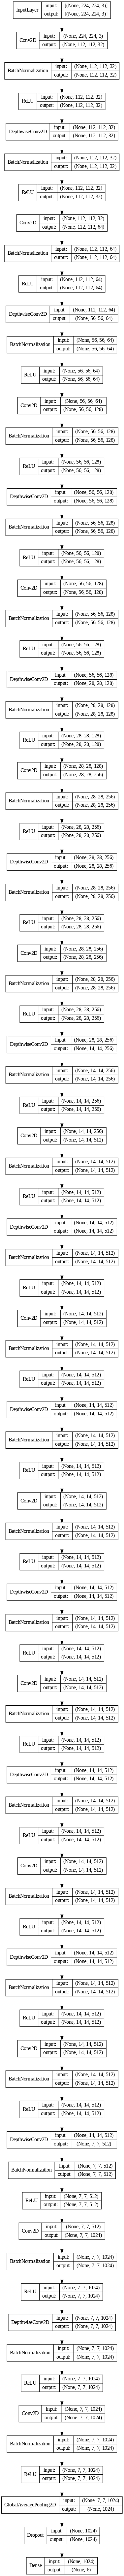

In [ ]:
plot_model(mobile_net_model, show_shapes=True, show_layer_names=False, dpi=80)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Finally, lets examine our model summary to understand the number of parameters involved:

In [ ]:
mobile_net_model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      864       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)      288       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      12

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

Our model comprises approximately 3.2 million trainable parameters.

<a id="Train_Scratch"></a>
# <b><span style='color:darkturquoise'>Step 5.2 |</span><span style='color:royalblue'> Training the Defined MobileNet Model</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>📝 Preparing the Model for Training:</font></h2>
    
Now, I am going to get our model prepared for training:
    
- I will choose the `adam` optimizer, known for adapting learning rates throughout training.
- I will use the `categorical_crossentropy` loss function, suitable for multi-class classification tasks.
- I will select `accuracy` as a metric for simplicity. Given our dataset's imbalance, I will utilize additional metrics to better assess our model performance later.

In [ ]:
mobile_net_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🛠️ Enhancing Training with Callbacks:</font></h2>
    
Next, I will define two key callbacks to enhance and monitor our training process:

1️⃣ **ReduceLROnPlateau**:
   - The `ReduceLROnPlateau` callback is used to reduce the learning rate by half (factor=0.5) whenever the validation loss does not improve for 15 consecutive epochs. This helps to adjust the learning rate dynamically, allowing the model to get closer to the global minimum of the loss function when progress has plateaued. This strategy can improve the convergence of the training process.

    
2️⃣ **EarlyStopping**:
   - The `EarlyStopping` callback is employed to monitor the validation loss and halt the training process when there hasn't been any improvement for 20 epochs, ensuring that the model doesn't waste computational resources and time. Furthermore, this callback restores the best weights from the training process, ensuring we conclude with the optimal model configuration from the epochs.

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🎯 Note:</font></h2>
    
I am not using the `ModelCheckpoint` callback in this context because I could save the model using `model.save()` after training. This saves the best weights from our training due to the `restore_best_weights=True` option in the `EarlyStopping` callback. The `ModelCheckpoint` callback is beneficial, especially in environments where training could be interrupted; it ensures you have a saved version of the best model up to the point of interruption. But if you're sure about the stability of your training environment, you might not find a necessity for this callback.

In [ ]:
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True, verbose=1)

<div style="border-radius:10px; padding: 15px; background-color:black; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🚀 Model Training:</font></h2>

In this step, I am going to set our model up for training using the `fit` method:

- **train_generator**: This feeds our model with batches of training data.
- **epochs**: The total number of iterations over the entire dataset. I will set this to `32` for our model.
- **validation_data**: Like the training generator, this provides batches of validation data for model evaluation after each epoch.
- **class_weight**: Given the imbalanced nature of our dataset, we're utilizing the weights we calculated earlier to assign different importance levels to each class. This helps to ensure our model remains unbiased towards the majority class.
- **callbacks**: The list of callbacks we've previously defined. They include the `reduce_lr` and `early_stopping` functions, which help in dynamically adjusting the learning rate and halting training when the model ceases to improve.

In [ ]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [ ]:
print("Assigned Class Weights:")
class_weights

Assigned Class Weights:


{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

In [ ]:
# Total number of epochs
num_epochs = 32

# Train the model
history = mobile_net_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/32
64/64 [==============================] - 385s 6s/step - loss: 1.7912 - accuracy: 0.3553 - val_loss: 1.8207 - val_accuracy: 0.1976 - lr: 0.0010
Epoch 2/32
64/64 [==============================] - 360s 6s/step - loss: 1.4970 - accuracy: 0.4438 - val_loss: 1.9896 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 3/32
64/64 [==============================] - 384s 6s/step - loss: 1.3556 - accuracy: 0.4958 - val_loss: 2.0199 - val_accuracy: 0.1976 - lr: 0.0010
Epoch 4/32
64/64 [==============================] - 364s 6s/step - loss: 1.2642 - accuracy: 0.5205 - val_loss: 1.8909 - val_accuracy: 0.1976 - lr: 0.0010
Epoch 5/32
64/64 [==============================] - 358s 6s/step - loss: 1.2034 - accuracy: 0.5403 - val_loss: 1.9314 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 6/32
64/64 [==============================] - 362s 6s/step - loss: 1.1342 - accuracy: 0.5661 - val_loss: 1.8892 - val_accuracy: 0.1976 - lr: 0.0010
Epoch 7/32
64/64 [==============================] - 356s 6s/step - loss: 1.1

<a id="Eval_Scratch"></a>
# <b><span style='color:darkturquoise'>Step 5.3 |</span><span style='color:royalblue'> Evaluating the Defined MobileNet Model</span></b>
⬆️ [Tabel of Contents](#contents_tabel)


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
During the evaluation process, I will encompass two distinct phases:
    
- Visualizing the Learning Curves
- Performance Metrics Assessment

<a id="curves_scratch"></a>
## <b><span style='color:darkturquoise'>Step 5.3.1 |</span><span style='color:royalblue'> Visualizing the Learning Curves</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

In this step, we will define a function to visualize the learning curves for Loss and Accuracy across epochs for both training and validation sets, providing insights into the quality of our trained model:

In [30]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

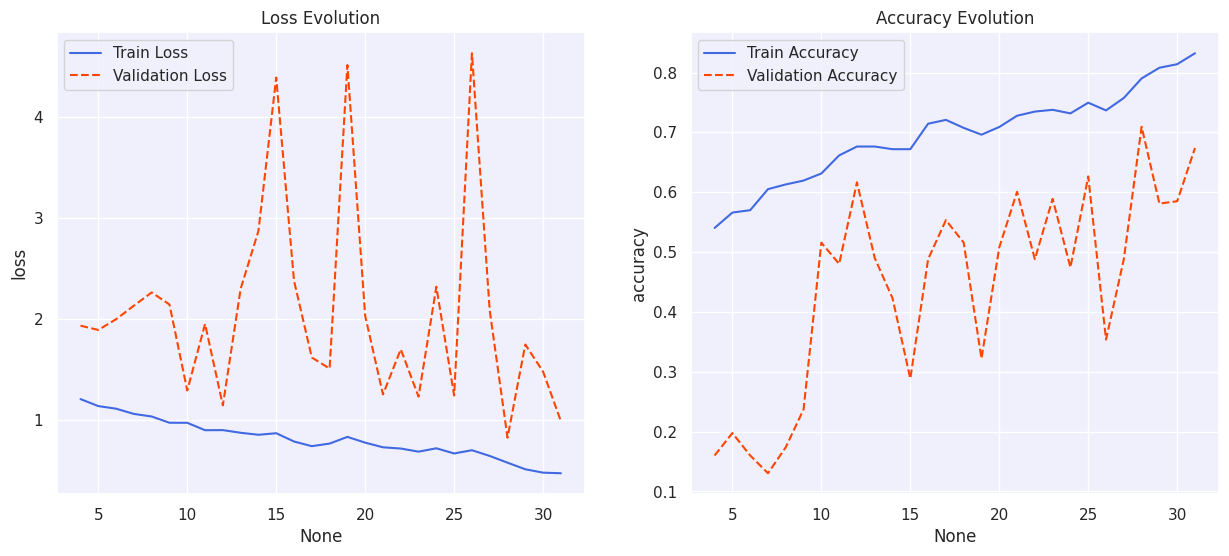

In [ ]:
plot_learning_curves(history)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>💡 Observations:</font></h2>

- **Training Metrics**: The model learns the training data well, as seen by decreasing loss and increasing accuracy.
- **Validation Fluctuations**: The validation loss has many ups and downs, suggesting the model isn't consistent on unseen data.
- **Overfitting Signs**: There's a clear difference between training and validation performance, hinting at overfitting.

<h3 align="left"><font color=royalblue> 🎯 Reasons for Fluctuations:</font></h3>    

1. **Aggressive Augmentation**: Our data changes might be too strong, making the model see very different images during training.
2. **Small Dataset**: Using a deep model like MobileNet on just 2000 images can make it memorize data rather than learn patterns, leading to unstable results.
3. **Class Weights**: While they help with imbalanced data, they might cause the model to be too focused on certain classes, affecting validation.
4. **Batch Size & Learning Rate**: Small batches can cause noisy updates, and a high learning rate might make the model skip optimal points.


<a id="metrics_scratch"></a>
## <b><span style='color:darkturquoise'>Step 5.3.2 |</span><span style='color:royalblue'> Performance Metrics Assessment</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
In this step, we will craft a function to evaluate our model using both performance metrics and a confusion matrix:

In [33]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

16/16 [==============================] - 17s 1s/step
              precision    recall  f1-score   support

   cardboard       0.73      0.85      0.79        81
       glass       0.63      0.63      0.63       100
       metal       0.66      0.77      0.71        82
       paper       0.64      0.83      0.72       119
     plastic       0.89      0.33      0.48        97
       trash       0.58      0.56      0.57        27

    accuracy                           0.67       506
   macro avg       0.69      0.66      0.65       506
weighted avg       0.70      0.67      0.66       506





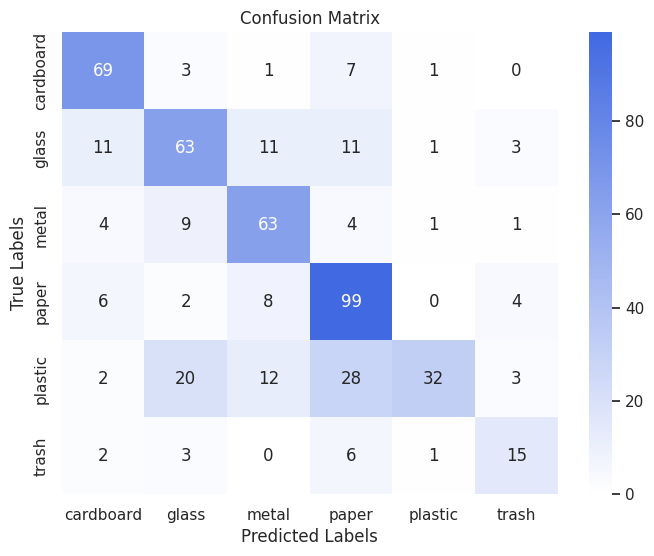

In [ ]:
evaluate_model_performance(mobile_net_model, val_generator, class_labels)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>💡 Model Performance Inferences:</font></h2>

- 1️⃣ **Overall Performance**:
   - The model showcases good accuracy and balanced metrics for most categories.

    
- 2️⃣ **High Performers**:
   - `cardboard`: Stands out with exceptional performance.
   - `paper`: Delivers strong results.
   - `glass`: Holds its own, even with a notable representation in the dataset.

    
- 3️⃣ **Areas to Improve**:
   - `trash`: The model finds this category a bit challenging, likely due to its lesser representation in the dataset.

    
- 4️⃣ **Class Weights Impact**:
   - Even with class weights, certain categories like `trash` pose challenges.
   - Categories with higher representation, such as `paper`, still perform admirably.


    
<h3 align="left"><font color=royalblue> 🎯 Recommendation:</font></h3>
    
Considering the challenges in classifying certain categories, implementing **transfer learning** could provide an improvement. Using pre-trained models and fine-tuning them for this specific task might help in better distinguishing between classes like `glass`, `plastic`, and `metal` and also improve performance on the `trash` category.


<a id="Transfer_Learning"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 6 | MobileNet with Transfer Learning</p>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🔄 Why We Chose Transfer Learning for Garbage Classification</font></h2>

__Classifying garbage__ is notably tough because of __the vast variety of items in each category__. With basic models, we might not achieve the best results. When using intricate models like __MobileNet__ on a smaller dataset, overfitting becomes a concern, and we might not see optimal performance. Adding __aggressive data augmentation__ provides some relief, but it's still not enough to train complex models like MobileNet effectively, especially when starting from scratch. The uneven distribution of data types compounds the issue, as we aim for consistent model performance across all garbage types.

This is where __Transfer Learning__ shines. Models pretrained on extensive datasets have learned features that can identify subtle differences between challenging categories. With transfer learning, we don't just accept the pretrained model as it is. Instead, we modify and fine-tune certain parts, especially the deeper layers, to cater to our specific needs. This approach lets us harness the power of established features while adapting the model to our dataset's specifics. As a result, our model becomes more robust and is less prone to overfitting.

<a id="Define_tf"></a>
# <b><span style='color:darkturquoise'>Step 6.1 |</span><span style='color:royalblue'> Loading MobileNet with Pre-trained Weights</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

First of all, I am going to load the MobileNet architecture pre-trained on the __ImageNet dataset__. I will exclude the top classifier layer to adjust for our specific 6-class task and set the input shape to `(224, 224, 3)` to align with our dataset's image dimensions:

In [ ]:
# Load the PretrainedMobileNet model with weights pre-trained on ImageNet
base_model = PretrainedMobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

17225924/17225924 [==============================] - 2s 0us/step


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Let's take a look at our `base_model` summary:

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Our `base_model` contains approximately 3.2 million trainable parameters!

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Let's find the total layers of __MobileNet__:

In [ ]:
len(base_model.layers)

86

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🔍 Deciding the Level of Transfer Learning</font></h2>

The level of transfer learning we adopt depends on two key aspects:
    
- 1️⃣ The size of our dataset (small or large).  
- 2️⃣ How similar our dataset is to the original dataset the pretrained model was trained on.

Given our circumstances, our dataset is small and varies from the original dataset (`imagenet`). If we kept the higher-level features of the pretrained model unchanged, they might not be as effective, since they've been tailored to a different set of data. Fully fine-tuning the entire model on our limited dataset isn't ideal either, as it could lead to overfitting.

A balanced approach is to freeze the earlier layers, which capture broad and general features, and fine-tune the latter layers.

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">


Given our objective to fine-tune the latter layers, we determined that only train __15% of last layers__ would be optimal. This ensures that the broad and general features from the initial blocks are retained, while the more specific features in the latter blocks can be fine-tuned to our dataset. Let's print out the names of the layers we want to train:

In [ ]:
for i, layer in enumerate(base_model.layers):
    if 73 <= i <= 86:
        print(i, layer.name)

73 conv_pad_12
74 conv_dw_12
75 conv_dw_12_bn
76 conv_dw_12_relu
77 conv_pw_12
78 conv_pw_12_bn
79 conv_pw_12_relu
80 conv_dw_13
81 conv_dw_13_bn
82 conv_dw_13_relu
83 conv_pw_13
84 conv_pw_13_bn
85 conv_pw_13_relu


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Let's freeze the layers up to __`conv_pad_12`__:

In [ ]:
# Freeze the first 70 layers
for layer in base_model.layers[:72]:
    layer.trainable = False

# Make the remaining layers trainable
for layer in base_model.layers[72:]:
    layer.trainable = True

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Afterward, we are going to extend the pre-trained base_model (MobileNet) by adding custom layers to tailor it for our specific classification task. After extracting features using MobileNet, we use a __Global Average Pooling__ layer to condense the spatial dimensions. A __dropout__ layer is added for regularization, reducing the risk of overfitting. Finally, a __dense__ layer with a softmax activation function is employed to classify the inputs into our 6 distinct classes:

In [ ]:
# Create the new model
def transfer_learning_mobilenet(input_shape=(224, 224, 3), n_classes=1000):
    # Load the pre-trained MobileNet model without the top layers
    base_model = PretrainedMobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the first 70 layers
    for layer in base_model.layers[:72]:
      layer.trainable = False

    # Make the remaining layers trainable
    for layer in base_model.layers[72:]:
      layer.trainable = True

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling
    x = Dense(1024, activation='relu')(x)  # Fully connected layer
    output = Dense(n_classes, activation='softmax')(x)  # Output layer

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    return model

mobilenet_transfer_model = transfer_learning_mobilenet(input_shape=(224, 224, 3), n_classes=num_classes)  # Adjust n_classes as needed

# Compile the model
mobilenet_transfer_model.compile(optimizer='adam',
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

Next, let's visualize the architecture of our new model:

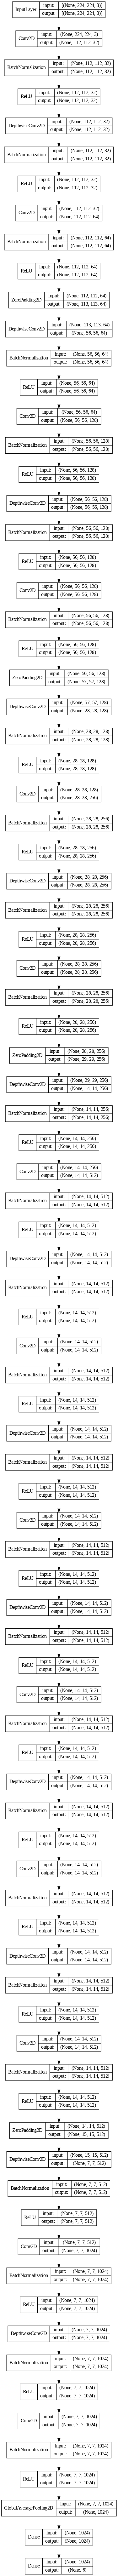

In [ ]:
plot_model(mobilenet_transfer_model, show_shapes=True, show_layer_names=False, dpi=80)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
We can also examine our model summary to understand the number of parameters involved:

In [ ]:
mobilenet_transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h3 align="left"><font color=royalblue>📉 Reduction in Trainable Parameters After Freezing Blocks</font></h3>

As observed from the model summary, after freezing the first four blocks of our MobileNet architecture, the number of trainable parameters significantly reduced to approximately 2.6 million, down from the initial 3.2 million. This change ensures a more balanced approach, reducing the risk of overfitting while capitalizing on the pre-trained knowledge of the model.

<a id="Preprocess_tf"></a>
# <b><span style='color:darkturquoise'>Step 6.2 |</span><span style='color:royalblue'> Applying MobileNet-specific Image Preprocessing </span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h3 align="left"><font color=royalblue>💡 Updating Data Preprocessing for MobileNet </font></h3>

MobileNet was originally trained with a unique preprocessing on the __ImageNet__ dataset. Not adhering to this preprocessing can result in reduced model performance. Therefore, we'll need to modify the generators we set up in __Step 3.3__. The two key changes are:
    
- Using the `preprocess_input` of MobileNet as the `preprocessing_function` for `ImageDataGenerator`.
- Removing the `rescale` argument from `ImageDataGenerator`, as this is already handled by `preprocess_input`.

Here's the updated approach:

In [ ]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rotation_range=60,                  # Randomly rotate the images by up to 60 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.20,                    # Randomly zoom in or out by up to 20%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    preprocessing_function=preprocess_input  # Add this line
)

# For the validation set, you might not have augmentation:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Add this line

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Let's utilize the above generators to produce data batches for both the training and validation phases:

In [ ]:
# Using flow_from_dataframe to generate batches
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(224, 224),              # Resize all images to size of 224x224
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(224, 224),              # Resize all images to size of 224x224
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


<a id="Train_tf"></a>
# <b><span style='color:darkturquoise'>Step 6.3 |</span><span style='color:royalblue'> Fine-tuning the Transfer Learning MobileNet Model</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

In this step, I am going to fine-tuning our model on our garbage dataset. Again, I will employ callbacks to adjust the learning rate when needed and to halt training early if there's no improvement, ensuring efficient and optimal training. The model will be also trained using class weights to account for potential class imbalances in the data.

In [28]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

# Total number of epochs
num_epochs = 32

# Train the model
history = mobilenet_transfer_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/32
64/64 [==============================] - 253s 4s/step - loss: 1.0826 - accuracy: 0.6640 - val_loss: 1.5134 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 2/32
64/64 [==============================] - 239s 4s/step - loss: 0.4277 - accuracy: 0.8397 - val_loss: 2.6191 - val_accuracy: 0.3715 - lr: 0.0010
Epoch 3/32
64/64 [==============================] - 203s 3s/step - loss: 0.3528 - accuracy: 0.8758 - val_loss: 4.3397 - val_accuracy: 0.2964 - lr: 0.0010
Epoch 4/32
64/64 [==============================] - 214s 3s/step - loss: 0.2507 - accuracy: 0.9060 - val_loss: 1.6700 - val_accuracy: 0.5573 - lr: 0.0010
Epoch 5/32
64/64 [==============================] - 215s 3s/step - loss: 0.1885 - accuracy: 0.9312 - val_loss: 2.0854 - val_accuracy: 0.5672 - lr: 0.0010
Epoch 6/32
64/64 [==============================] - 198s 3s/step - loss: 0.2223 - accuracy: 0.9179 - val_loss: 8.1406 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 7/32
64/64 [==============================] - 196s 3s/step - loss: 0.1

<a id="Eval_tf"></a>
# <b><span style='color:darkturquoise'>Step 6.4 |</span><span style='color:royalblue'> Evaluating the Transfer Learning MobileNet Model</span></b>
⬆️ [Tabel of Contents](#contents_tabel)


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

We once again, I am going to conduct our evaluation in two steps.

<a id="curves_tf"></a>
## <b><span style='color:darkturquoise'>Step 6.4.1 |</span><span style='color:royalblue'> Visualizing the Learning Curves</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

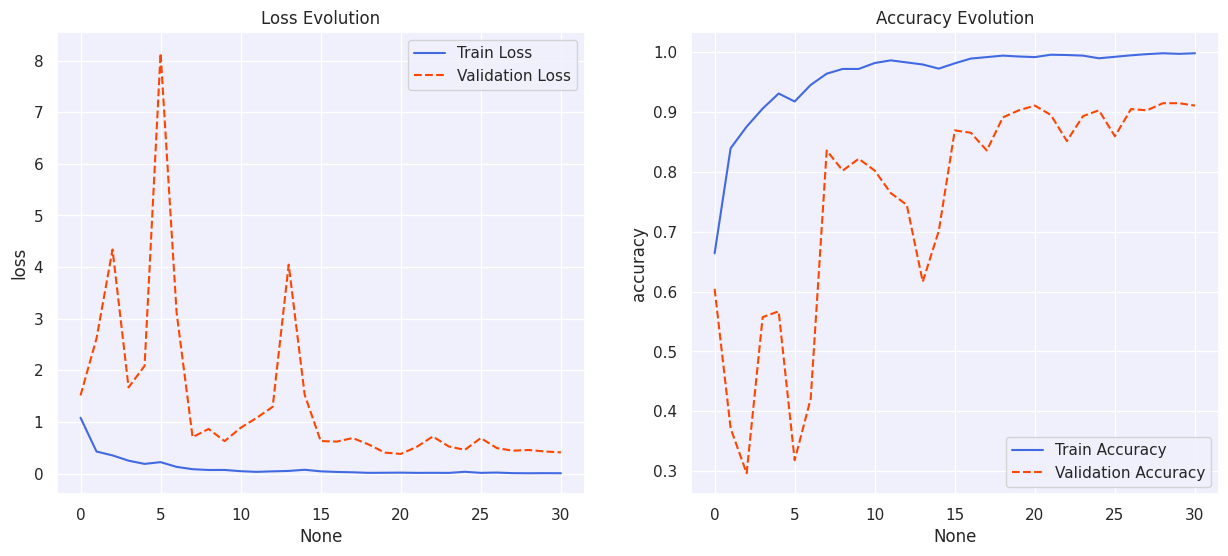

In [31]:
plot_learning_curves(history, start_epoch=1)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>💡 Fine-Tuned MobileNet Observations:</font></h2>

- 1️⃣ **Loss Evolution**:
   - **Train Loss**: Rapidly decreases and stabilizes after around 15 epochs.
   - **Validation Loss**: Starts off high but quickly converges to a lower value.

    
- 2️⃣ **Accuracy Evolution**:
   - **Train Accuracy**: Rapid ascent, approaching 100%. This demonstrates the model's capability to adapt quickly to the training data.
   - **Validation Accuracy**: Impressive progress, reaching around 91% in just a few epochs and maintaining that level. This is a significant improvement over the scratch-built model.

    
- 3️⃣ **Comparison with Scratch-Built MobileNet**:
   - The fine-tuned MobileNet achieves high validation accuracy much faster, showcasing the benefits of transfer learning.
   - The disparity between training and validation metrics is less pronounced than before, which is a positive sign.

<h3 align="left"><font color=royalblue> 🎯 Inference:</font></h3>

The fine-tuned MobileNet benefits from previous learnings, allowing for rapid convergence and a commendable validation accuracy of 91% within a few epochs. The performance is superior to the scratch-built variant, highlighting the advantages of transfer learning.

<a id="metrics_tf"></a>
## <b><span style='color:darkturquoise'>Step 6.4.2 |</span><span style='color:royalblue'> Performance Metrics Assessment</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

16/16 [==============================] - 33s 2s/step
              precision    recall  f1-score   support

   cardboard       0.97      0.89      0.93        81
       glass       0.89      0.94      0.91       100
       metal       0.94      0.90      0.92        82
       paper       0.90      0.95      0.92       119
     plastic       0.92      0.89      0.91        97
       trash       0.79      0.81      0.80        27

    accuracy                           0.91       506
   macro avg       0.90      0.90      0.90       506
weighted avg       0.91      0.91      0.91       506





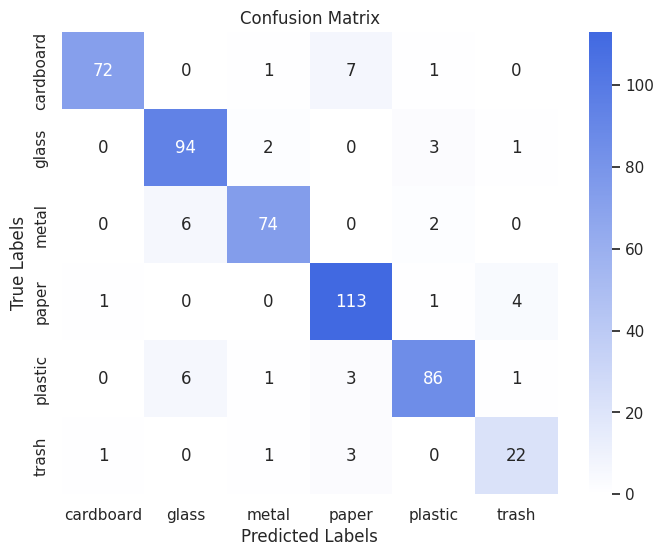

In [34]:
evaluate_model_performance(mobilenet_transfer_model, val_generator, class_labels)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>💡 Model Performance Inferences:</font></h2>

- 1️⃣ **Overall Accuracy**: The model boasts an impressive accuracy.
- 2️⃣ **Cardboard**,  **Glass**, **Metal**, **Paper**, and **Plastic** are standout performers, demonstrating good results.
- 3️⃣ **Trash** due to imbalanced data, the performance still lower than others.
- 4️⃣ Consistent F1-scores across categories highlight the model's reliability in making balanced predictions.

    
<h3 align="left"><font color=royalblue> 🎯 Inference:</font></h3>
    
With transfer learning, the MobileNet model has shown noticeable improvements compared to its from-scratch counterpart. This underlines the power and efficiency of leveraging pre-trained knowledge in domain-specific tasks.
    

In [35]:
# Convert the model with quantization for optimization
converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_transfer_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model
with open('mobilenet_transfer_model_quantized.tflite', 'wb') as f:
    f.write(tflite_quantized_model)

In [ ]:
def predict_img(image_path)
    # Load the image
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize to the input size of the MobileNet model

    # Convert the image to a numpy array
    img_array = np.array(img)

    # Normalize the image (same as preprocessing_function in training)
    img_array = (img_array.astype(np.float32) / 127.5) - 1.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Load the TensorFlow Lite model
    interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Garbagage_classification/mobilenet_transfer_model_quantized.tflite")
    # Allocate tensors
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set the input tensor with the image data
    interpreter.set_tensor(input_details[0]['index'], img_array)
    # Run inference
    interpreter.invoke()

    # Get the output predictions
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(output_data)
    print(f"Predicted Class: {class_labels[predicted_class_index]} with confidence {output_data[0][predicted_class_index]}")

Predicted Class: metal with confidence 0.9293588995933533


<h2 align="left"><font color=royalblue>Best Regards</font></h2>